# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 19 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,4 months and 4 days !!!
H2O cluster name:,H2O_from_python_patrickh_mkdb28
H2O cluster total nodes:,1
H2O cluster free memory:,10.43 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


# Known Signal Generating Functions

***

The objective of this notebook is to test and compare local explanations created by the popular methods: LIME, Treeinterpreter, and Shapley on an XGBoost model trained on a known signal generating function with noise: 

$$ y = x_1 * x_4 + |x_8| * (x_9)^2 + e $$

In this notebook we prevent XGBoost from overfitting to the known signal by providing a validation set.

# Data Generation and XGBoost Training
***

In [5]:
ds_ = DataMakerAndGetter(nrows=200000, target='binary', one_function=True, noise=True)
rson = ds_.make_random_with_signal()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
y = 'target'
X = [name for name in rson.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [7]:
rson[y] = rson[y].asfactor()
train, valid, _ = rson.split_frame([0.4, 0.3], seed = 12345)
print(train.shape)
print(valid.shape)

(80049, 18)
(59947, 18)


In [8]:
rsontrain_pd = train.as_data_frame()
rsonvalid_pd = valid.as_data_frame()

In [9]:
rsontrain_dm = xgb.DMatrix(rsontrain_pd[X],
                           rsontrain_pd[y])
rsonvalid_dm = xgb.DMatrix(rsonvalid_pd[X],
                           rsonvalid_pd[y])

In [10]:
ave_y = rsontrain_pd['target'].mean()
print(ave_y)

0.42154180564404303


In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.9,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 12,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.001,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rsontrain_dm, 'train'), (rsonvalid_dm, 'eval')]

rson_model = xgb.train(params, 
                       rsontrain_dm, 
                       400,
                       early_stopping_rounds=50,
                       evals=watchlist, 
                       verbose_eval=True)

[0]	train-auc:0.662655	eval-auc:0.637728
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.701792	eval-auc:0.669751
[2]	train-auc:0.756935	eval-auc:0.722574
[3]	train-auc:0.792702	eval-auc:0.758416
[4]	train-auc:0.814924	eval-auc:0.782046
[5]	train-auc:0.81665	eval-auc:0.782009
[6]	train-auc:0.826115	eval-auc:0.79378
[7]	train-auc:0.829857	eval-auc:0.797381
[8]	train-auc:0.831158	eval-auc:0.798757
[9]	train-auc:0.832994	eval-auc:0.801017
[10]	train-auc:0.83283	eval-auc:0.799187
[11]	train-auc:0.836437	eval-auc:0.80342
[12]	train-auc:0.836729	eval-auc:0.802991
[13]	train-auc:0.839226	eval-auc:0.806378
[14]	train-auc:0.840314	eval-auc:0.808367
[15]	train-auc:0.841832	eval-auc:0.81027
[16]	train-auc:0.843173	eval-auc:0.8109
[17]	train-auc:0.843384	eval-auc:0.810746
[18]	train-auc:0.844492	eval-auc:0.812145
[19]	train-auc:0.845608	eval-auc:0.813533
[20]	train-auc:0.845638	eval-auc:0.8

[191]	train-auc:0.875243	eval-auc:0.821628
[192]	train-auc:0.875285	eval-auc:0.821636
[193]	train-auc:0.875431	eval-auc:0.82174
[194]	train-auc:0.87557	eval-auc:0.821793
[195]	train-auc:0.87559	eval-auc:0.821794
[196]	train-auc:0.875616	eval-auc:0.821846
[197]	train-auc:0.87576	eval-auc:0.821851
[198]	train-auc:0.875841	eval-auc:0.821877
[199]	train-auc:0.875861	eval-auc:0.821877
[200]	train-auc:0.876006	eval-auc:0.821913
[201]	train-auc:0.876058	eval-auc:0.821966
[202]	train-auc:0.876177	eval-auc:0.821929
[203]	train-auc:0.876354	eval-auc:0.821938
[204]	train-auc:0.876465	eval-auc:0.82192
[205]	train-auc:0.876617	eval-auc:0.822009
[206]	train-auc:0.876719	eval-auc:0.822077
[207]	train-auc:0.876908	eval-auc:0.82217
[208]	train-auc:0.877023	eval-auc:0.822187
[209]	train-auc:0.877167	eval-auc:0.822194
[210]	train-auc:0.877189	eval-auc:0.822159
[211]	train-auc:0.877284	eval-auc:0.822168
[212]	train-auc:0.877436	eval-auc:0.822174
[213]	train-auc:0.877567	eval-auc:0.822214
[214]	train-auc:0

[383]	train-auc:0.892321	eval-auc:0.823225
[384]	train-auc:0.89238	eval-auc:0.823224
[385]	train-auc:0.892507	eval-auc:0.823215
[386]	train-auc:0.892617	eval-auc:0.82319
[387]	train-auc:0.892649	eval-auc:0.82321
[388]	train-auc:0.892674	eval-auc:0.823212
[389]	train-auc:0.89271	eval-auc:0.823205
[390]	train-auc:0.892739	eval-auc:0.823216
[391]	train-auc:0.892819	eval-auc:0.823202
[392]	train-auc:0.892898	eval-auc:0.823223
[393]	train-auc:0.893005	eval-auc:0.823223
[394]	train-auc:0.893051	eval-auc:0.823198
[395]	train-auc:0.893092	eval-auc:0.823163
[396]	train-auc:0.893113	eval-auc:0.823163
[397]	train-auc:0.893189	eval-auc:0.823159
[398]	train-auc:0.893237	eval-auc:0.823173
[399]	train-auc:0.893294	eval-auc:0.823183


# Global Variable Importance 

***

#### XGBoost variable importance

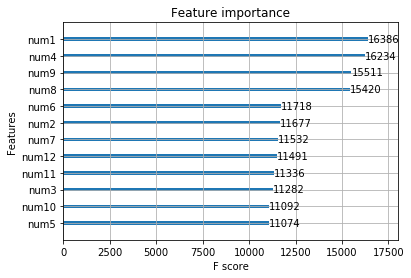

In [12]:
_ = plot_importance(rson_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(rson_model)

Weight,Feature
0.1208,num9
0.1077,num1
0.1076,num4
0.0974,num8
0.0714,num2
0.0713,num10
0.0711,num12
0.0710,num7
0.0709,num11
0.0707,num5


#### Shapley variable importance

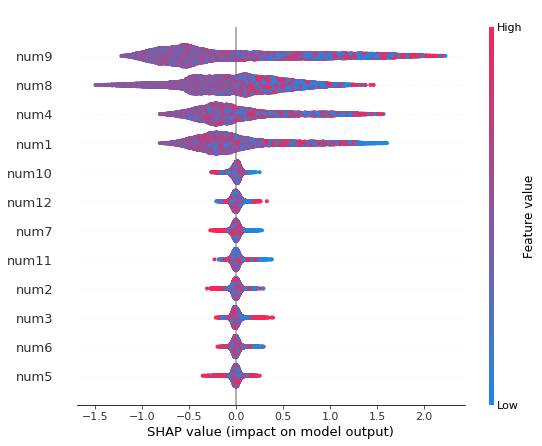

In [14]:
shap_values = rson_model.predict(rsonvalid_dm, pred_contribs=True)
shap.summary_plot(shap_values, rsonvalid_pd[X])

#### Example Shapley dependence (you can try other variables)

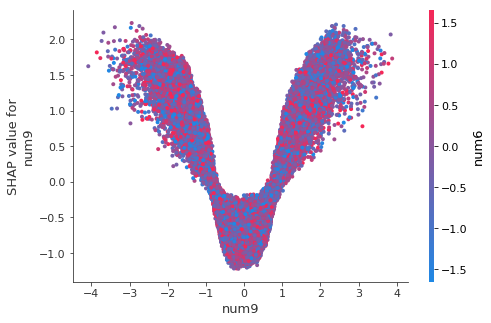

In [15]:
var = "num9" 
shap.dependence_plot(var, shap_values, rsonvalid_pd[X])

#### Function for calculating partial dependence

In [16]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [17]:
par_dep_num9 = par_dep('num9', rsonvalid_pd[X], rson_model)

In [18]:
par_dep_num9

,num9,partial_dependence
0,-4.080806,0.764284
1,-3.682671,0.764284
2,-3.284536,0.764284
3,-2.886401,0.766352
4,-2.488266,0.758818
5,-2.090131,0.706026
6,-1.691996,0.679998
7,-1.293861,0.575561
8,-0.895725,0.450925
9,-0.497590,0.297198


#### Bind XGBoost predictions to training data

In [19]:
rson_preds = pd.DataFrame(rson_model.predict(rsonvalid_dm))

In [20]:
rson_decile_frame = pd.concat([rsonvalid_pd, rson_preds], axis=1)
rson_decile_frame = rson_decile_frame.rename(columns={0: 'predict'})
rson_decile_hframe = h2o.H2OFrame(rson_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
rson_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,function,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,1,0.290944
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,1,0.826447
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,1,0.633627
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,1,0.143136
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,1,10,1,0.157180


#### Find percentiles of XGBoost predictions

In [22]:
rson_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', rson_decile_hframe)

In [23]:
rson_percentile_dict

{0: 137359,
 10: 95964,
 20: 148660,
 30: 73527,
 40: 127436,
 50: 95138,
 60: 190656,
 70: 162259,
 80: 101443,
 90: 55938,
 99: 191654}

#### Calculate ICE curve values

In [24]:
# retreive bins from original partial dependence calculation
bins_num9 = list(par_dep_num9['num9'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(rson_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for num11 across percentiles at bins_num11 intervals
    par_dep_num9[col_name] = par_dep('num9', 
                                     rsonvalid_pd[rsonvalid_pd['row_id'] == int(rson_percentile_dict[i])][X], 
                                     rson_model, 
                                     bins=bins_num9)['partial_dependence']


#### Display partial dependence and ICE for num9

In [25]:
par_dep_num9

,num9,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-4.080806,0.764284,0.515088,0.458600,0.810318,0.839874,0.727913,0.733273,0.890809,0.759960,0.841190,0.849099,0.923298
1,-3.682671,0.764284,0.515088,0.458600,0.810318,0.839874,0.727913,0.733273,0.890809,0.759960,0.841190,0.849099,0.923298
2,-3.284536,0.764284,0.515088,0.458600,0.810318,0.839874,0.727913,0.733273,0.890809,0.759960,0.841190,0.849099,0.923298
3,-2.886401,0.766352,0.520794,0.464279,0.810370,0.842923,0.732415,0.737994,0.893012,0.764360,0.844218,0.849204,0.924900
4,-2.488266,0.758818,0.490112,0.446488,0.820998,0.847313,0.711169,0.733383,0.884938,0.762031,0.835098,0.853508,0.923788
5,-2.090131,0.706026,0.333122,0.345124,0.806049,0.758585,0.570403,0.678371,0.880654,0.716486,0.836961,0.837111,0.894585
6,-1.691996,0.679998,0.238474,0.276057,0.809211,0.726572,0.561841,0.691951,0.887216,0.694028,0.848665,0.860497,0.900010
7,-1.293861,0.575561,0.162722,0.163089,0.757918,0.455597,0.329458,0.714196,0.871064,0.474803,0.787196,0.870774,0.889968
8,-0.895725,0.450925,0.123221,0.183517,0.371279,0.290782,0.246867,0.568430,0.791420,0.428179,0.760115,0.865656,0.849518
9,-0.497590,0.297198,0.097429,0.148200,0.164114,0.156815,0.203267,0.301832,0.528376,0.255190,0.774756,0.814984,0.813392


#### Plot partial dependence and ICE

In [26]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


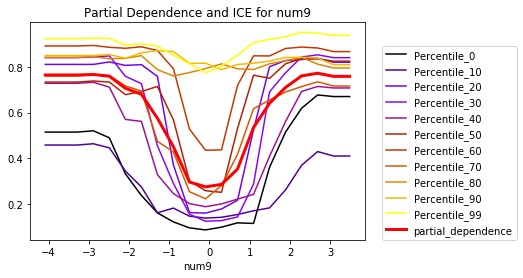

In [27]:
plot_par_dep_ICE('num9', par_dep_num9)

#### Train single h2o decision tree

In [28]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=rson_decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip


#### Create GraphViz dot file

In [29]:
# title for plot
title = 'Known Signal Data (with Validation) Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Known Signal Data (with Validation) Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [30]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


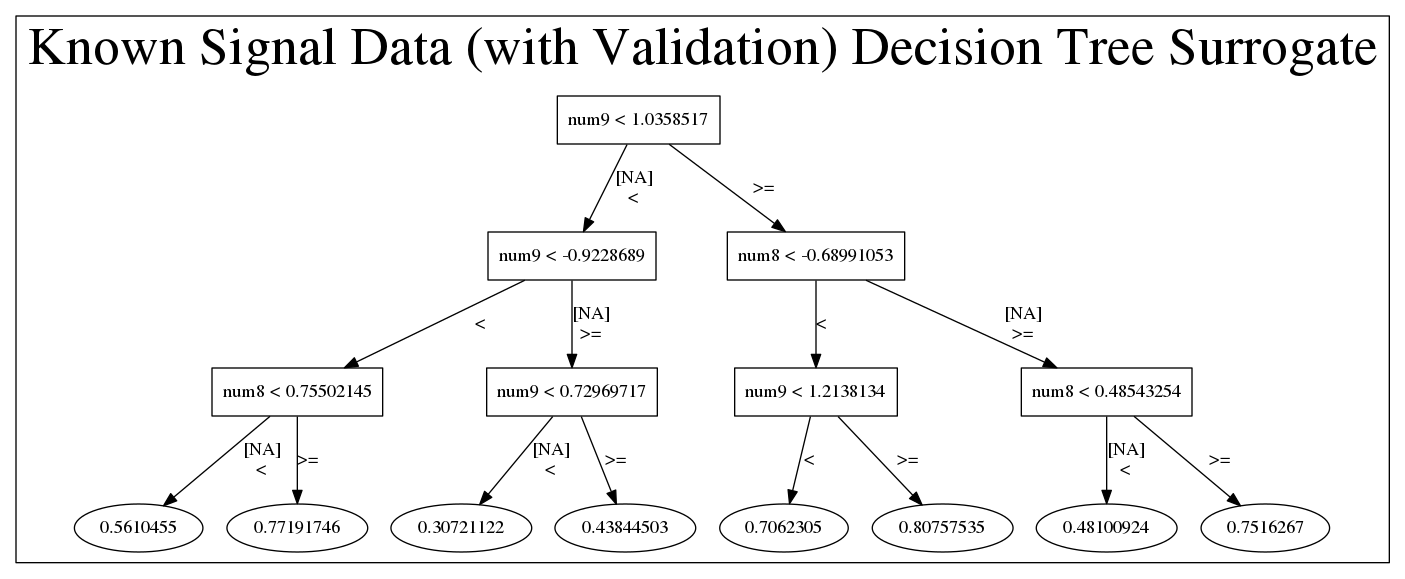

In [31]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

## Explanation at three deciles

#### Utility functions that displays the expected contribution of relevant variables with a short description at the chosen decile

In [32]:
def get_decile_describe(decile):
    
    row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
    print("This is the %dth decile of the predicted value with row_id %d, target %d, and prediction %.2f Base value: %.2f " 
          % (decile, row['row_id'].item(), row['target'].item(), row['predict'].item(), shap_values[row.index[0],:][-1]))
    print ("Signal generation function 1")
    return print_function1_contribs(row)
    
def print_function1_contribs(row):
    
    num1_contrib = row['num1'].iloc[0]
    print('Expected num1 contribution:', num1_contrib)
    
    num4_contrib = row['num4'].iloc[0]
    print('Expected num4 contribution:', num4_contrib)
    
    num8_contrib = np.abs(row['num8'].iloc[0]) 
    print('Expected num8 contribution:', num8_contrib)
    
    num9_contrib = np.power(row['num9'].iloc[0], 2)
    print('Expected num9 contribution:', num9_contrib)

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [33]:
def eli5_dd(decile):
    row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
    eli5_df = eli5.explain_prediction_df(rson_model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(rson_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [34]:
# learn what to discretize from var imp 
explainer = LIMEExplainer(training_frame=rsonvalid_pd, X=X, model=rson_model, 
                          discretize=['num1', 'num4', 'num8', 'num9'])

def lime(decile):
    row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
    explainer.explain(row.index[0]) 

#### Utility function that displays the Shapley results at the choosen decile

In [35]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [36]:
decile = 10
row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
get_decile_describe(decile)

This is the 10th decile of the predicted value with row_id 95964, target 0, and prediction 0.16 Base value: -0.31 
Signal generation function 1
Expected num1 contribution: -0.4216850443895841
Expected num4 contribution: 0.37885845199664536
Expected num8 contribution: 0.024253756378015703
Expected num9 contribution: 0.39266143744558285


### Shapley values

       Approximate Local Contributions
num8                         -0.569841
num4                         -0.289396
num9                         -0.284384
num1                         -0.280561
num6                         -0.046446
num11                        -0.028922
num12                        -0.026485
num5                         -0.015966
num7                         -0.004286
num2                          0.010295
num10                         0.045226
num3                          0.112277 

Shapley sum:  -1.6899536
Model prediction:  -1.6899587188515475


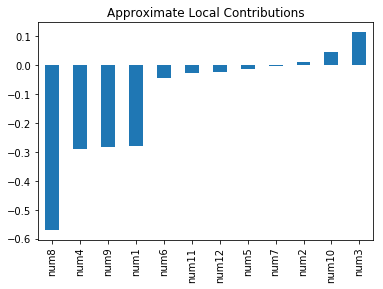

In [37]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7f82a26c7748>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num10', weight=0.10201076074969175, std=None, value=-0.4537975138249077), FeatureWeight(feature='num3', weight=0.05774663291390271, std=None, value=-1.7874908198931398), FeatureWeight(feature='num7', weight=0.013732020945534117, std=None, value=-1.25938894323154), FeatureWeight(feature='<BIAS>', weight=0.004983725973563514, std=None, value=1.0)], neg=[FeatureWeight(feature='num9', weight=-0.40245099717630756, std=None, value=-0.6266270321695218), FeatureWeight(feature='num4', weight=-0.3834046428509033, std=None, value=0.37885845199664536), FeatureWeight(feature='num8', weight=-0.36731029564132583, std=None, value=0.024253756378015703), FeatureWeight(feature='num1', weight=-0.2675510001850203, std=None, value=-0.4216850443895841), FeatureWeight(feature='num6', weight=-0.05801635590612978, std=None, value=0.9172301026562276), FeatureWeight(feature='num12', weight=-0.04437324815197228, std=None, value=-0.6661076177316573), FeatureWeight(feature='num5', weight=-0.021326147449007078, std=None, value=-1.2947798231494885), FeatureWeight(feature='num11', weight=-0.005070006135298216, std=None, value=-0.9647600970473702), FeatureWeight(feature='num2', weight=-0.002481936886727997, std=None, value=-0.027004383874489904)], pos_remaining=0, neg_remaining=0), proba=None, score=-1.3735114897999998, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

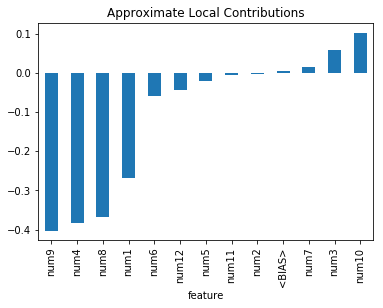

In [38]:
eli5_dd(decile)

In [39]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -1.6899587188515475


### LIME


Model Prediction: 0.16
Local GLM Prediction: 0.13
Local GLM R-square: 0.72
Local GLM Intercept: 0.53

Approximate Local Contributions:
                    Input  Local Contribution
0    num1.(-0.432, 0.251]           -0.100006
1     num4.(0.368, 1.049]           -0.089839
2    num8.(0.0137, 0.693]           -0.083726
3   num9.(-0.637, 0.0421]           -0.079577
4                    num3           -0.037860
5                    num5           -0.011937
6                    num2           -0.001499
7                    num7           -0.001275
8                   num10           -0.000191
9                   num11           -0.000131
10                  num12           -0.000033
11                   num6            0.003524
None


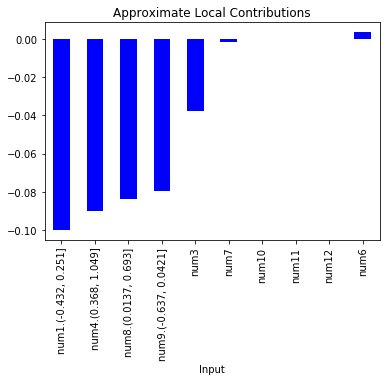

In [40]:
lime(decile)

##  Median of predictions

### Shapley values

In [41]:
decile = 50
row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
get_decile_describe(decile)

This is the 50th decile of the predicted value with row_id 95138, target 0, and prediction 0.30 Base value: -0.31 
Signal generation function 1
Expected num1 contribution: 1.0422585464813874
Expected num4 contribution: 0.021680042515330008
Expected num8 contribution: 1.7587244123577566
Expected num9 contribution: 0.3627935777276772


       Approximate Local Contributions
num9                         -0.603729
num4                         -0.365437
num10                        -0.078617
num11                        -0.045578
num12                        -0.045546
num1                         -0.026244
num3                         -0.005573
num6                         -0.005323
num7                         -0.002489
num5                          0.013923
num2                          0.132833
num8                          0.510614 

Shapley sum:  -0.8326299
Model prediction:  -0.8326233535361498


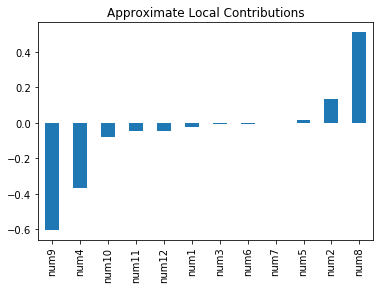

In [42]:
shapley(row)

### TreeInterpreter 

Explanation(estimator='<xgboost.core.Booster object at 0x7f82a26c7748>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num8', weight=0.4020624461030096, std=None, value=-1.7587244123577566), FeatureWeight(feature='num2', weight=0.27656840398535876, std=None, value=2.6475184328656867), FeatureWeight(feature='num5', weight=0.07499611957729496, std=None, value=-0.2328003495127472), FeatureWeight(feature='num7', weight=0.033640720295611326, std=None, value=1.9829074933547817), FeatureWeight(feature='num3', weight=0.01803633845406969, std=None, value=-1.6372172870688881), FeatureWeight(feature='<BIAS>', weight=0.004983725973563514, std=None, value=1.0)], neg=[FeatureWeight(feature='num9', weight=-0.5336043425354844, std=None, value=-0.6023234826301206), FeatureWeight(feature='num4', weight=-0.4469034450767946, std=None, value=0.021680042515330008), FeatureWeight(feature='num10', weight=-0.12143957760801016, std=None, value=1.7076096865061858), FeatureWeight(feature='num11', weight=-0.08802287724249039, std=None, value=1.0798725420492), FeatureWeight(feature='num12', weight=-0.07429751821144374, std=None, value=0.06066340304883469), FeatureWeight(feature='num1', weight=-0.0346348216538974, std=None, value=1.0422585464813874), FeatureWeight(feature='num6', weight=-0.027561077360787164, std=None, value=0.151061999413301)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.5161759053000001, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

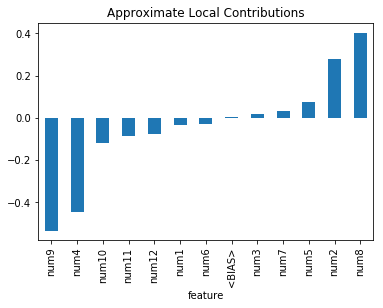

In [43]:
eli5_dd(decile)

In [44]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -0.8326233535361498


### LIME


Model Prediction: 0.30
Local GLM Prediction: 0.47
Local GLM R-square: 0.57
Local GLM Intercept: 0.70

Approximate Local Contributions:
                   Input  Local Contribution
0    num1.(1.032, 1.715]           -0.051828
1   num4.(0.0111, 0.692]           -0.048694
2   num8.(-1.769, -1.09]           -0.045714
3  num9.(-0.613, 0.0664]           -0.044481
4                   num2           -0.039183
5                   num3            0.000067
None


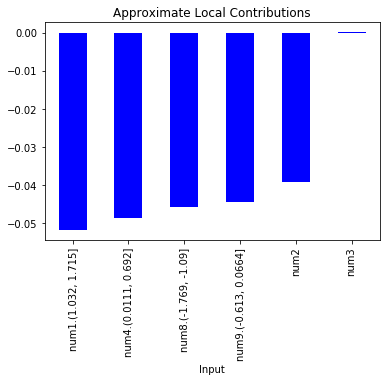

In [45]:
lime(decile)

##  90th decile of model predictions

In [46]:
decile = 90
row = rson_decile_frame[rson_decile_frame['row_id'] == rson_percentile_dict[decile]]
get_decile_describe(decile)

This is the 90th decile of the predicted value with row_id 55938, target 1, and prediction 0.82 Base value: -0.31 
Signal generation function 1
Expected num1 contribution: -2.535112587207601
Expected num4 contribution: -1.1992599108813538
Expected num8 contribution: 1.6982985433410651
Expected num9 contribution: 1.4875659372727585


### Shapley values

       Approximate Local Contributions
num2                         -0.049885
num5                         -0.035751
num10                        -0.033061
num11                        -0.029794
num7                          0.000515
num3                          0.001633
num6                          0.002359
num12                         0.048726
num1                          0.443882
num9                          0.457448
num4                          0.490990
num8                          0.539581 

Shapley sum:  1.5251791
Model prediction:  1.5251729211827163


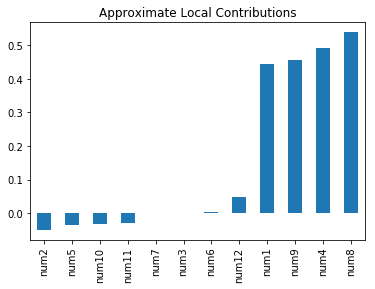

In [47]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7f82a26c7748>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num9', weight=0.8507626960025352, std=None, value=1.2196581231118655), FeatureWeight(feature='num8', weight=0.8335258387493709, std=None, value=1.6982985433410651), FeatureWeight(feature='num4', weight=0.22779118905987686, std=None, value=-1.1992599108813538), FeatureWeight(feature='num12', weight=0.07413353807050964, std=None, value=-0.7675905610972527), FeatureWeight(feature='num11', weight=0.04160252515074615, std=None, value=-0.7800953918087568), FeatureWeight(feature='num6', weight=0.01718958161189037, std=None, value=0.09550405357158284), FeatureWeight(feature='<BIAS>', weight=0.004983725973563514, std=None, value=1.0)], neg=[FeatureWeight(feature='num5', weight=-0.08874069023234404, std=None, value=0.5915341016455244), FeatureWeight(feature='num1', weight=-0.08171176721829726, std=None, value=-2.535112587207601), FeatureWeight(feature='num2', weight=-0.028387161082275878, std=None, value=-1.0185209319391868), FeatureWeight(feature='num3', weight=-0.007644283046928315, std=None, value=0.08399464954037499), FeatureWeight(feature='num7', weight=-0.0009733157161996966, std=None, value=-1.1826772354451591), FeatureWeight(feature='num10', weight=-0.0009117603224463558, std=None, value=0.8549694701147593)], pos_remaining=0, neg_remaining=0), proba=None, score=1.8416201169999988, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

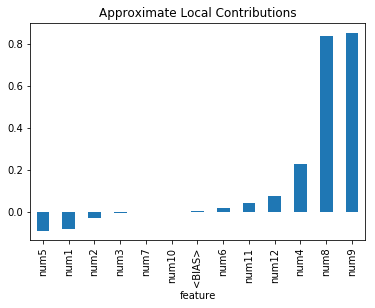

In [48]:
eli5_dd(decile)

In [49]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  1.5251729211827163


### LIME


Model Prediction: 0.82
Local GLM Prediction: 0.86
Local GLM R-square: 0.40
Local GLM Intercept: 0.76

Approximate Local Contributions:
                   Input  Local Contribution
0                   num3           -0.000300
1                   num5           -0.000013
2    num9.(1.209, 1.888]            0.011454
3    num8.(1.688, 2.367]            0.014929
4   num4.(-1.21, -0.529]            0.019579
5  num1.(-2.546, -1.863]            0.029107
6                   num2            0.029999
None


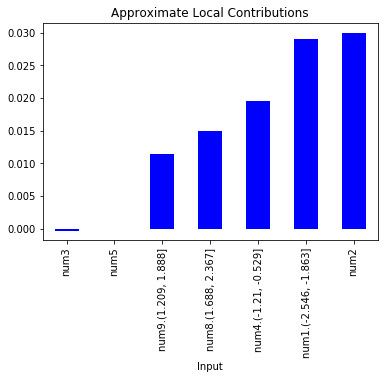

In [50]:
lime(decile)